(1286, 7)
           visit         ra        dec band           mjd  limitingMagnitude  \
0  2024110800245  53.327236 -28.072055    i  60623.258521            24.2174   
1  2024110800246  53.327425 -28.072347    r  60623.259329            24.6158   
2  2024110800247  53.141378 -28.131211    r  60623.259895            24.6542   
3  2024110800248  53.141304 -28.131213    i  60623.260739            24.2033   
4  2024110800249  53.188483 -28.208666    i  60623.261307            24.1606   

     seeing  
0  0.844020  
1  0.903278  
2  0.871491  
3  0.828322  
4  0.863370  
[np.int64(1), np.int64(3), np.int64(6), np.int64(7), np.int64(8), np.int64(13), np.int64(14), np.int64(16), np.int64(23), np.int64(28), np.int64(30), np.int64(37), np.int64(41), np.int64(47)]
Number of valid detections with SNR > 10 is 14
[np.int64(10), np.int64(13), np.int64(17), np.int64(22), np.int64(23), np.int64(25), np.int64(35), np.int64(36), np.int64(37), np.int64(42), np.int64(47)]
Number of valid detections with

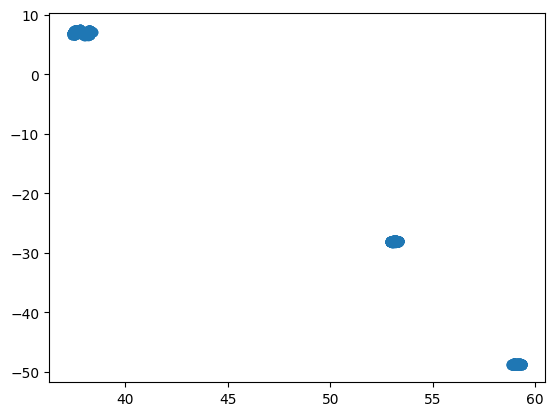

In [7]:

import pandas as pd
import numpy as np
from shapely.geometry import box
from skysurvey import Survey
from skysurvey.tools.utils import get_skynoise_from_maglimit
from skysurvey.target import SNeIa
from skysurvey.target import core
from shapely.ops import unary_union
from skysurvey.effects import mw_extinction
import matplotlib.pyplot as plt
from skysurvey import dataset
import matplotlib.pyplot as plt
from astropy.time import Time

import warnings
warnings.filterwarnings('ignore')

parquet_path = "dp1_visits-ECDFS_EDFS_Fornax_LELF.parquet"
df = pd.read_parquet(parquet_path)

# Removing FORNAX region from code (or any region)
ra_center = 40.00
dec_center = -34.45
radius_deg = 1.0  # degrees

# Compute angular separation using a sphere ???
def angular_sep(ra1, dec1, ra2, dec2):
    ra1, dec1, ra2, dec2 = map(np.radians, [ra1, dec1, ra2, dec2])
    return np.degrees(
        np.arccos(
            np.sin(dec1) * np.sin(dec2) +
            np.cos(dec1) * np.cos(dec2) * np.cos(ra1 - ra2)
        )
    )

# Apply filter
mask = angular_sep(df["ra"], df["dec"], ra_center, dec_center) >= radius_deg
df_filtered = df[mask]

# Inspect result
print(df_filtered.shape)
print(df_filtered.head())

plt.scatter(df_filtered['ra'],df_filtered['dec'])

simdata = pd.DataFrame({
    "skynoise": df_filtered["limitingMagnitude"].apply(get_skynoise_from_maglimit, zp=30).values,
    "mjd": df_filtered["mjd"].values,
    "band": "lsst" + df_filtered["band"].values,
    "gain": 1.0,
    "zp": 30,
    "ra": df_filtered["ra"].values,
    "dec": df_filtered["dec"].values
}, index=df_filtered.index)

fov_deg = 40.0 / 60.0
half_size = fov_deg / 2.0
footprint = box(-half_size, -half_size, half_size, half_size)

sur = Survey.from_pointings(simdata, footprint=footprint)

tiles = []
for _, row in df.iterrows():
    ra = row["ra"]
    dec = row["dec"]
    tile = box(ra - half_size, dec - half_size, ra + half_size, dec + half_size)
    tiles.append(tile)

# Time range of the survey
tstart, tstop = sur.get_timerange()
skyarea = unary_union(tiles)

runs_list = []
while len(runs_list) <100:
    try:
        snia = SNeIa.from_draw(
            tstart=tstart,
            tstop=tstop,
            skyarea=skyarea,
            zmin=0.1,
            zmax=1.0,  #Note : redshift changed to 2
            effect=mw_extinction,
            template='salt2-extended'
            )
        dset = dataset.DataSet.from_targets_and_survey(snia, sur,discard_bands=["lsstu"])
    except:
        print("failed")
        continue

    

    # Unitl this point the code is similar to yesterday

    # In this function I try to merge the photometry points for a given int(MJD)
    # For each available band in a light curve and for each unique MJD, I take a weighted average of 
    # flux and fluxerr weighted by inverse of the fluxerr
    # I also make sure the datframe is same format as the dset.data
    def change_dataset_entry(dset):
        idx =  dset.obs_index.to_numpy()
        list_df_all = []

        for index in idx:
            new_data = dset.data.xs(index).copy()
            new_data['mjd_int'] = new_data['mjd'].astype(int)
            lc_band = new_data.groupby('band')
            list_df = []
            for band, df_band in lc_band:
                lc_band_g = df_band.groupby('mjd_int')
                for mjd, sub_df in lc_band_g:
                    sub_df['w'] = 1/(sub_df['fluxerr']**2)
                    sub_df['weighted_f'] = sub_df['flux']*sub_df['w']/(sub_df['w'].sum())
                    sub_df['mjd'] = mjd
                    dict={
                        'index_obs': [sub_df.index[0]],
                        'fieldid': [sub_df['fieldid'].values[0]],
                        'band': [sub_df['band'].values[0]],
                        'mjd' : [mjd],  
                        'zp'  : [30],
                        'zpsys' : ['ab'],
                        'gain'  : [1.0],
                        'skynoise' : [sub_df['skynoise'].mean()],
                        'flux' : [sub_df['weighted_f'].sum()],    
                        'fluxerr' : [np.power(sub_df['w'].sum(),-0.5)]}
                
                    list_df.append( pd.DataFrame.from_dict(dict))
                                            

            df = pd.concat(list_df)
            df.reset_index(drop=True,inplace=True)

            index_tuples = [(index, a) for a in df.index_obs]
            multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['index', 'index_obs'])
            df.drop('index_obs',axis=1, inplace=True)
            df = df.set_index(multi_index)
            list_df_all.append(df)

        final_df = pd.concat(list_df_all)
        return final_df


    # For each light curve i compute the SNR and then if any entry in any band 
    # satisfies the threshold, i count them as detections 
    # This can be further changes depending on weather we want more cuts
    def num_of_detections_new(df, SNR):
        indices = np.unique(df.index.get_level_values(0).to_numpy())
        valid_light_curves = []
        valid_SNR_index = []
        for idx in indices:
            list_df = []
            lc = df.xs(idx)
            SNR_vals = lc['flux']/lc['fluxerr']
            cond = SNR_vals > SNR
            if (cond.sum() > 7) and (len(lc)>=7):
                valid_SNR_index.append(idx)
                valid_light_curves.append(lc)

        print(valid_SNR_index)
        print(f"Number of valid detections with SNR > {SNR} is {len(valid_SNR_index)}")
        return valid_SNR_index, valid_light_curves

    df = change_dataset_entry(dset)
    valid_idx, valid_lightcurves = num_of_detections_new(df, 10)
    runs_list.append(len(valid_idx))

mean = np.array(runs_list).mean()
sd = np.array(runs_list).std()

print(mean, sd)


# # Plotting individual light curves
# # The zp coedd and conversions are taken from skysurvey. Hope they are correct!!
# # This function saves N  valid ligh curves which can change between the runs
# def plot_lightcurve(i, df):
#     coef = 10 ** (-(df["zp"] - 25) / 2.5)
#     df["flux_zp"] = df["flux"] * coef
#     df["fluxerr_zp"] = df["fluxerr"] * coef

#     from matplotlib import dates as mdates        
#     locator = mdates.AutoDateLocator()
#     formatter = mdates.ConciseDateFormatter(locator)

#     fig, ax = plt.subplots()

#     ax.xaxis.set_major_locator(locator)
#     ax.xaxis.set_major_formatter(formatter)
#     grouped_df = df.groupby('band')
#     color = {
#         'lsstu' : 'blue',
#         'lsstr' : 'red',
#         'lsstg' : 'green',
#         'lssti' : 'indigo',
#         'lsstz' : 'pink',
#         'lssty' : 'yellow'
#     }
#     for group, band_df in grouped_df:
#         times = Time(band_df["mjd"], format="mjd").datetime
#         ax.scatter(times, band_df['flux_zp'],c=color[group],label=group)
#         ax.errorbar(times, band_df["flux_zp"],
#             yerr= band_df["fluxerr_zp"],
#             ls="None", marker="None", ecolor="grey", 
#             zorder=3)
#         ax.set_ylabel("Flux[zp=25]")
#         plt.legend()

#         plt.savefig(f"LC_{i}.png")



# for i, index in enumerate(valid_idx):
#     plot_lightcurve(i, valid_lightcurves[i])